In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pd_reader
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds
import datetime
import math
import os 
from tqdm import tqdm 
import pyfolio

%matplotlib inline

In [2]:
## Feed Data into backtrader
# ticker1 = 'AAL'
# aal = pd.read_csv(f".\\bt_stock_data\{ticker1}.csv", index_col=0, parse_dates=True)
# aal_feed = bt.feeds.PandasData(dataname=aal, openinterest=-1)

In [111]:
## Startegy
from turtle import pos

holding_dict = {}
initial_cap = 1000000
class BuyAndHoldStrategy(bt.Strategy):
    
    def __init__(self):
        self.pending_orders = dict()
        
    # def notify_order(self, order):
    #     if not order is None:

    #         if order.status == order.Completed:
    #             symbol = self.pending_orders[order.ref]
    #             print('%s: %s order filled' % (self.datetime.date(), symbol))
            
    #! this line of code is part of solution described above
    def prenext(self):
        self.next()
    
    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order

    def next(self):
        for i, d in enumerate(self.datas):
            #! this line of code is part of solution described above
            #! check if instrument is available for trading

            can_trade =  self.datetime.date() in self.datas[i]._dataname.index 
            position = self.broker.getposition(self.datas[i])
            no_position = not position

            if can_trade:
                ta = self.datas[i]._dataname['transactionAmounts'].loc[self.datetime.date()]
                # rta = self.datas[i]._dataname['rank_transactionAmounts'].loc[self.datetime.date()]
                # sdrta = self.datas[i]._dataname['sum_decen_rank_transactionAmounts'].loc[self.datetime.date()]
                tn = self.datas[i]._dataname['numTransactions'].loc[self.datetime.date()]
                # rta = self.datas[i]._dataname['numTransactions_industry_neutral_rank'].loc[self.datetime.date()]
                if ~np.isnan(ta) and ~np.isnan(tn) and ~np.isinf(ta) and ~np.isinf(tn):
                    if (tn > 0) & (ta < 0) :
                        # volume = self.datas[i]._dataname['volume'].loc[self.datetime.date()]
                        # prc = self.datas[i]._dataname['close'].loc[self.datetime.date()]
                        # we want to allocate $20000 in each instrument, but as order will
                        # be executed only at the next days's open price, we leave a margin of $1000
                        # to make sure that order will not be cancelled due to lack of cash
                        holding_dict[i] = 0
                        # order = self.order_target_value(data=self.datas[i], target= np.sign(rta-0.5) * initial_cap * np.abs(rta-0.5))
                        order = self.order_target_value(data=self.datas[i], target = np.sign(ta) * min(np.abs(ta)/200, 50000))
                        if not order is None:
                            self.pending_orders[order.ref] = d._name
                            # print('%s: %s order submitted' % (self.datetime.date(), d._name))      
                elif position is not None:
                    holding_period = 2
                    if i in holding_dict:
                        holding_dict[i] += 1
                    if (i in holding_dict) and (holding_dict[i] % holding_period == 0):
                        order = self.order_target_value(data=self.datas[i], target = 0)
                    else:
                        order = self.order_target_value(data=self.datas[i], target = position.size * position.price * 0.98)
                    if not order is None:
                        self.pending_orders[order.ref] = d._name
                        print('%s: %s order submitted' % (self.datetime.date(), d._name))   


In [77]:
bt_stock_data_dir = "./bt_stock_data/"
df0 = pd.read_csv(bt_stock_data_dir + f"/AAL.csv", index_col=0)
min_date = df0.index[0]
max_date = df0.index[-1]
bad_tickers = []
for file in tqdm(os.listdir(bt_stock_data_dir)):
       df = pd.read_csv(bt_stock_data_dir + file , index_col=0)
       if len(df.index) != len(df0.index):
              bad_tickers.append(file[:-4])

100%|██████████| 480/480 [00:01<00:00, 263.88it/s]


100%|██████████| 480/480 [00:02<00:00, 176.93it/s]


validnum:  438
2018-01-03: AAL order submitted
2018-01-03: ANET order submitted
2018-01-03: BAX order submitted
2018-01-03: CMCSA order submitted
2018-01-03: COF order submitted
2018-01-03: CPRT order submitted
2018-01-03: CRL order submitted
2018-01-03: DFS order submitted
2018-01-03: DGX order submitted
2018-01-03: DTE order submitted
2018-01-03: EA order submitted
2018-01-03: FANG order submitted
2018-01-03: FBHS order submitted
2018-01-03: FDX order submitted
2018-01-03: FOX order submitted
2018-01-03: GILD order submitted
2018-01-03: GLW order submitted
2018-01-03: KMX order submitted
2018-01-03: LKQ order submitted
2018-01-03: MA order submitted
2018-01-03: MTCH order submitted
2018-01-03: NKE order submitted
2018-01-03: NWS order submitted
2018-01-03: ON order submitted
2018-01-03: PAYC order submitted
2018-01-03: PEG order submitted
2018-01-03: PG order submitted
2018-01-03: PH order submitted
2018-01-03: PRU order submitted
2018-01-03: PXD order submitted
2018-01-03: RJF order

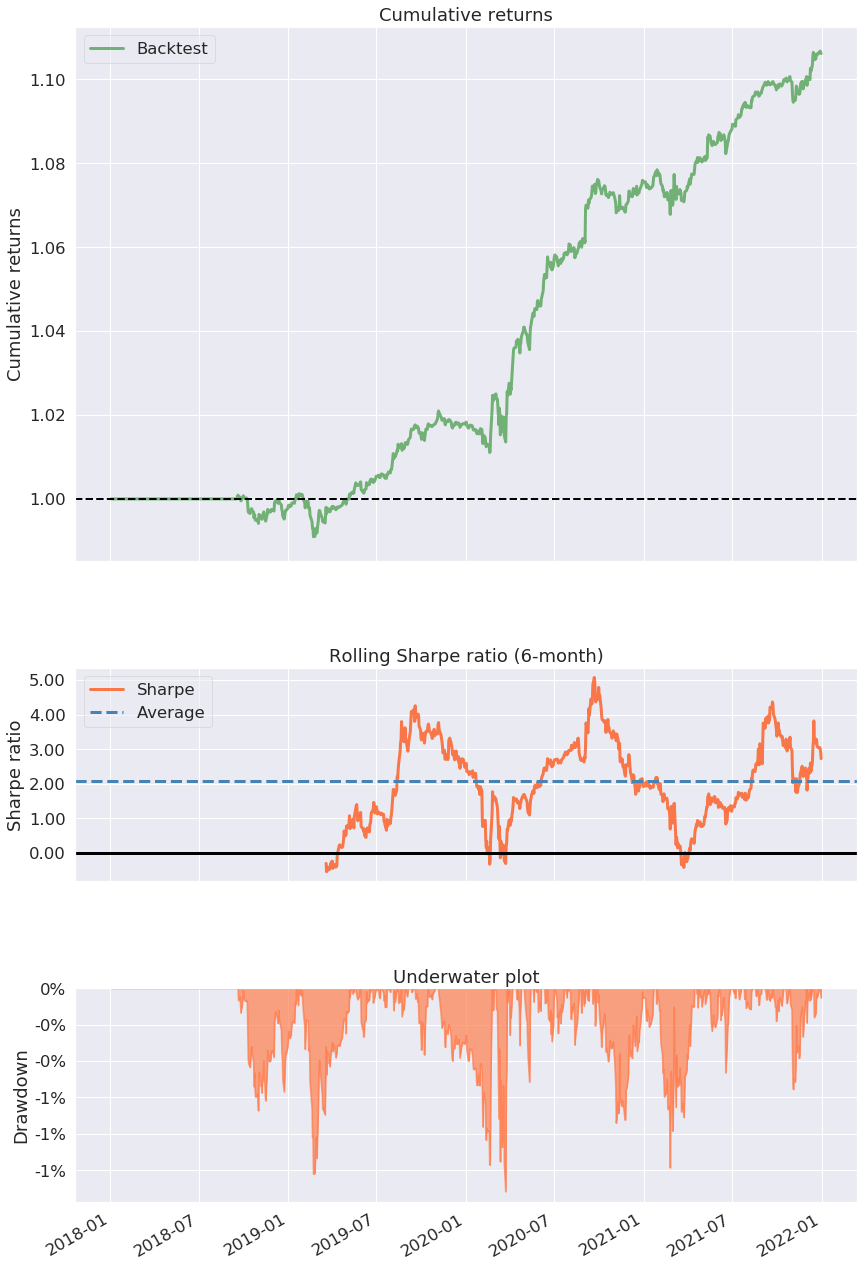

In [112]:
## Initialize backtesting   
%matplotlib inline
cerebro = bt.Cerebro(stdstats=False)
cnt = 0
for file in tqdm(os.listdir(bt_stock_data_dir)):
    ticker = file[:-4]
    df_feed = pd.read_csv(bt_stock_data_dir + f"/{ticker}.csv", index_col=0, parse_dates=True).loc[min_date:max_date]
    if df_feed.shape[0] > 0 and (df_feed.shape[0] == len(df_feed.index.unique())):
        if ticker in ['CRM', 'TECH', 'DLTR', 'V']:
            continue
        if ticker in bad_tickers:
            continue
        cerebro.adddata(bt.feeds.PandasData(dataname=df_feed, openinterest=-1), name=ticker)
        cnt += 1
print("validnum: ", cnt)
cerebro.broker.setcash(10000*cnt)
# cerebro.broker.setcommission(commission=0.0005)  # 0.5% of the operation value
cerebro.addstrategy(BuyAndHoldStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')
cerebro.addanalyzer(bt.analyzers.Returns, _name='_Returns', tann=252)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_SharpeRatio', timeframe=bt.TimeFrame.Days, annualize=True, riskfreerate=0) 
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown')

strats = cerebro.run()
pyfoliozer = strats[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
# pyfolio.create_full_tear_sheet(
#     returns,
#     positions=positions,
#     transactions=transactions,
#     # live_start_date='2005-05-01',  # This date is sample specific
#     round_trips=True)
# cplots = cerebro.plot()
b,a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns -  b * sp500_beta)

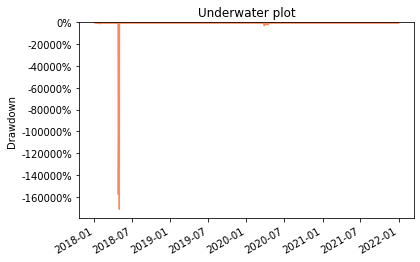

In [38]:
# pyfolio.tears.create_round_trip_tear_sheet(returns, positions=positions, transactions=transactions)
pyfolio.plotting.plot_drawdown_underwater(returns=returns)
# pyfolio.plotting.show_worst_drawdown_periods(returns)

In [7]:
sp500_beta = pd.read_csv("./sp500_beta.csv", index_col=0)
sp500_beta.index = [pd.Timestamp(t, tz='UTC') for t in sp500_beta.index]
sp500_beta = sp500_beta['Close']

In [59]:
def reg(x, y):
    mx, my = np.nanmean(x), np.nanmean(y)
    beta = np.nansum((x-mx)*(y-my))/np.nansum((x-mx)**2)
    intercept = my - beta*mx 
    return beta, intercept

def rolling_reg(x, y, window=90):
    mx, my = x.rolling(window).mean(), y.rolling(window).mean()
    beta = ((x-mx)*(y-my)).rolling(window).sum()/(np.power(x-mx, 2)).rolling(window).sum()
    intercept = my - beta * mx
    return beta, intercept

holding period 1 - forward 

In [ ]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 2 - forward

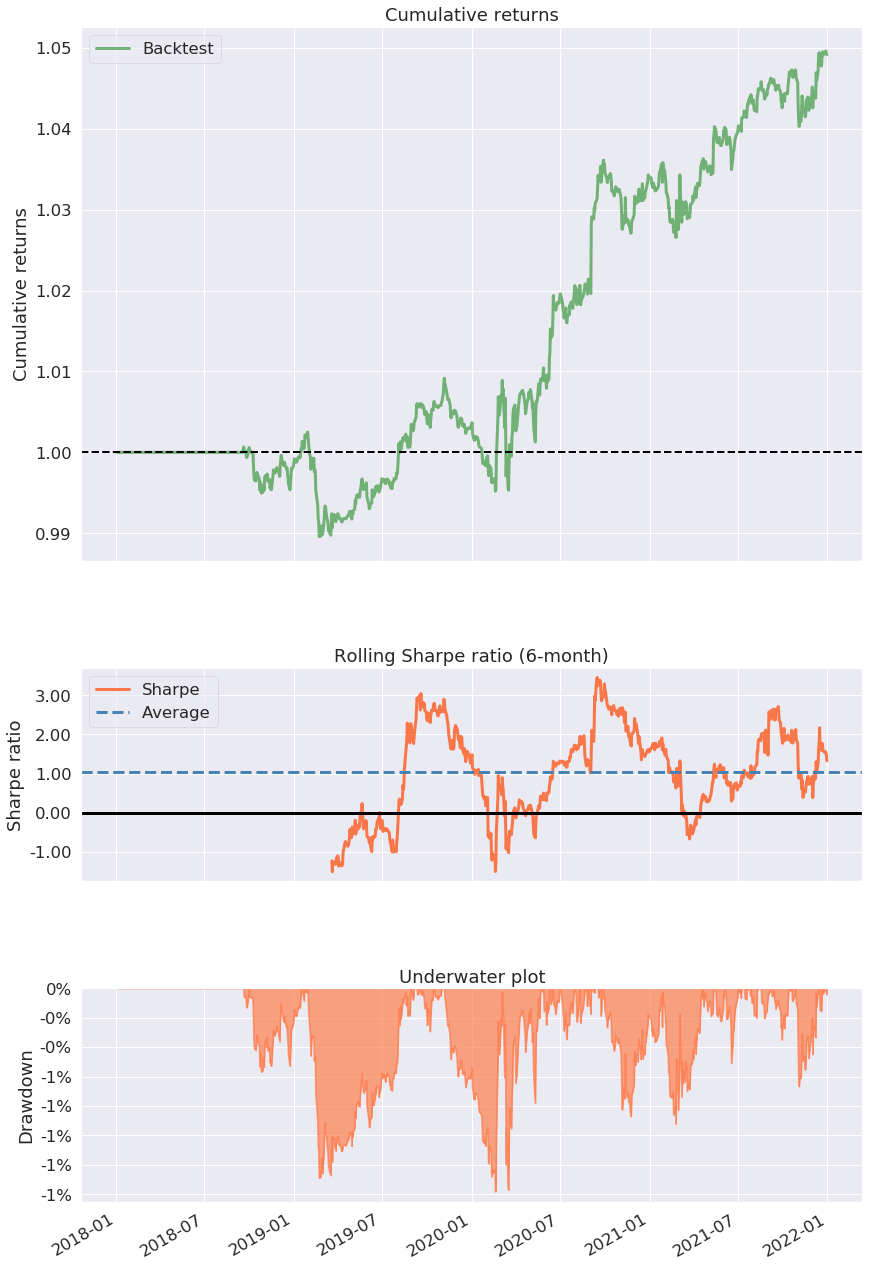

In [68]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 3 - forward

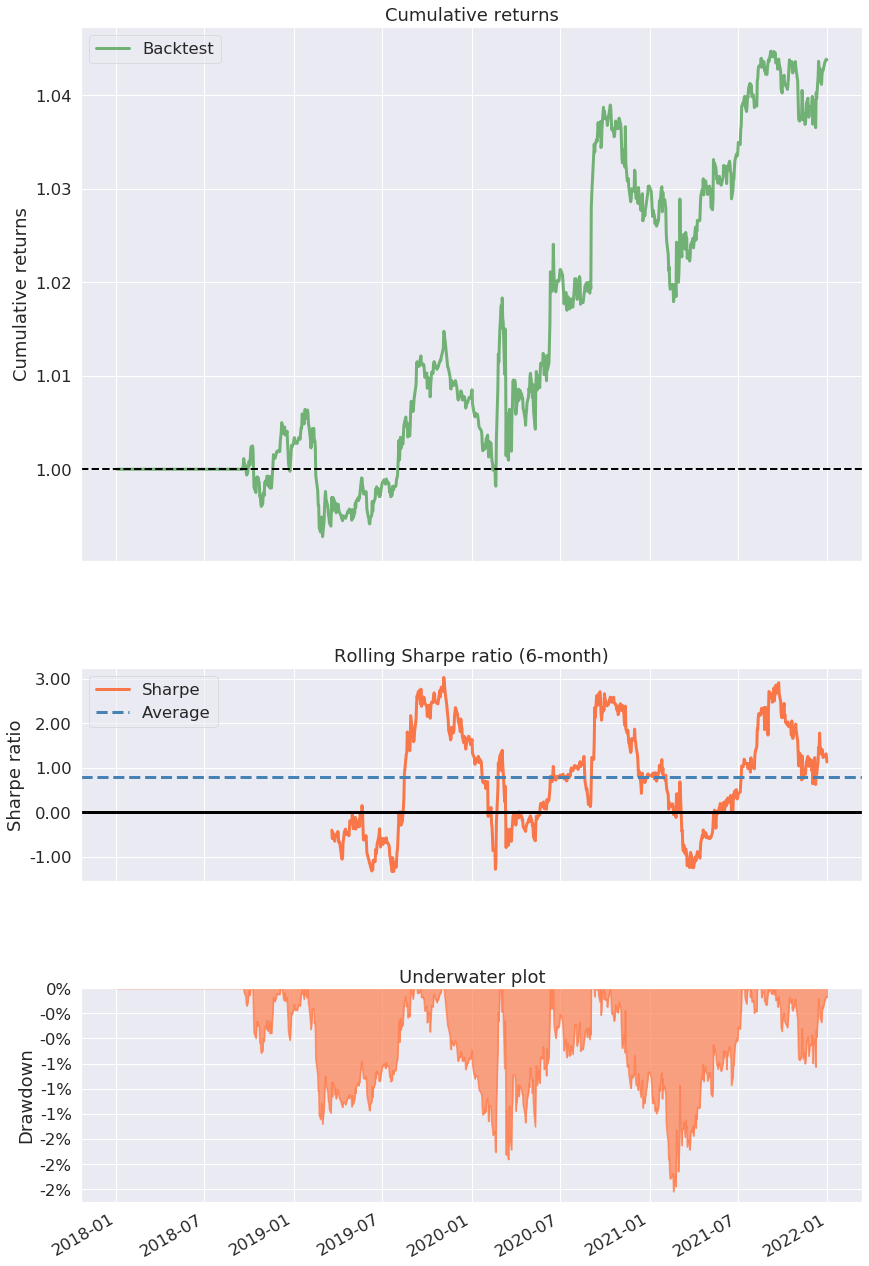

In [60]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 5 - forward

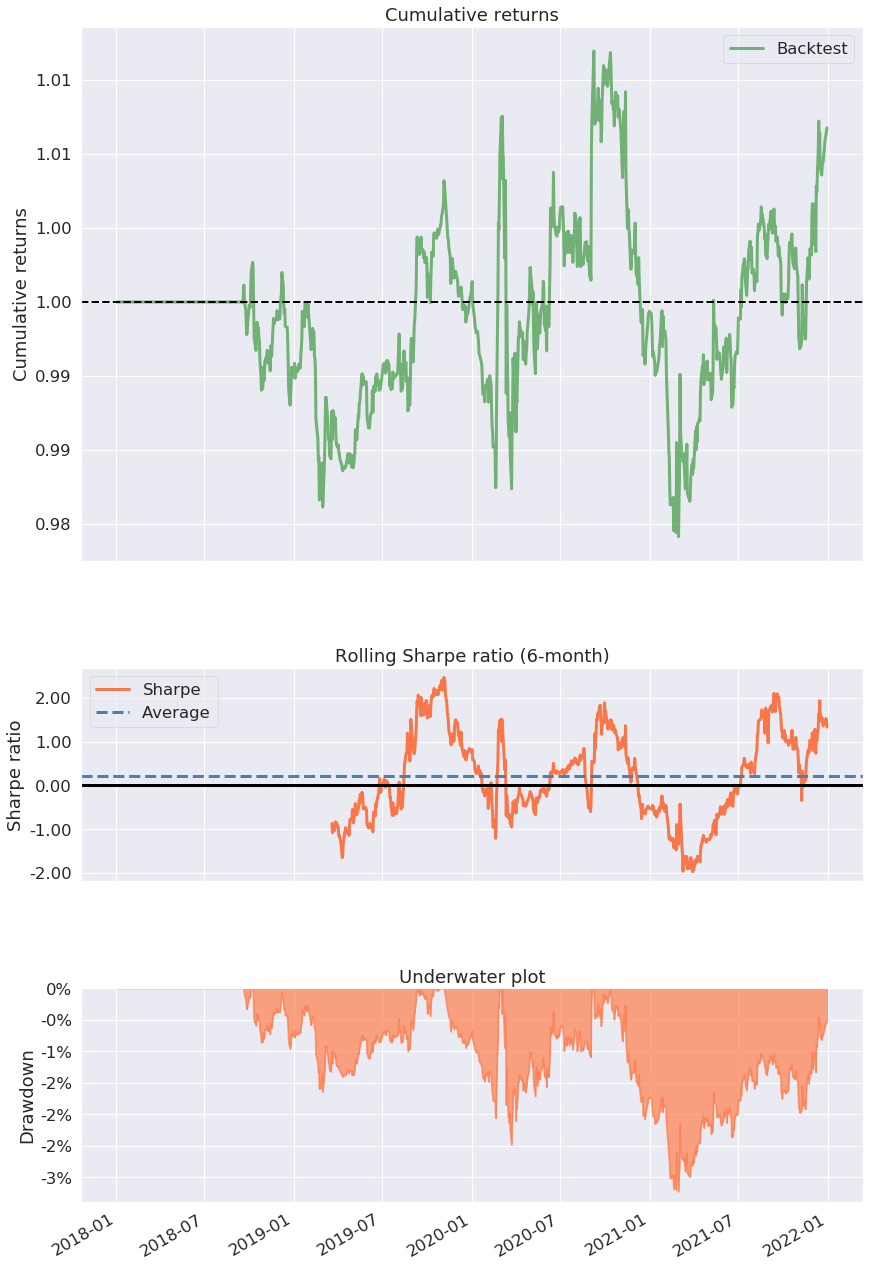

In [71]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 10 - forward

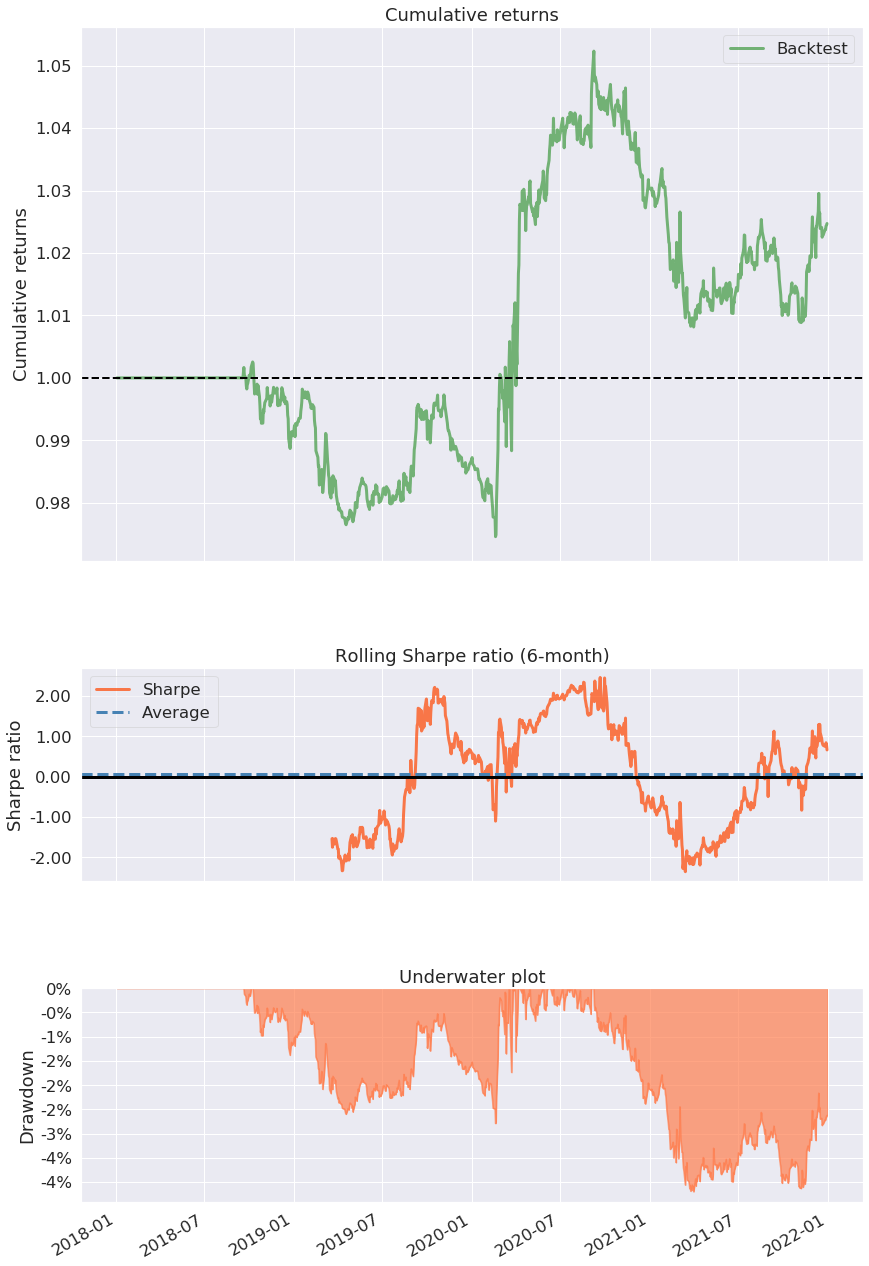

In [64]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 1 - filing date - no tc

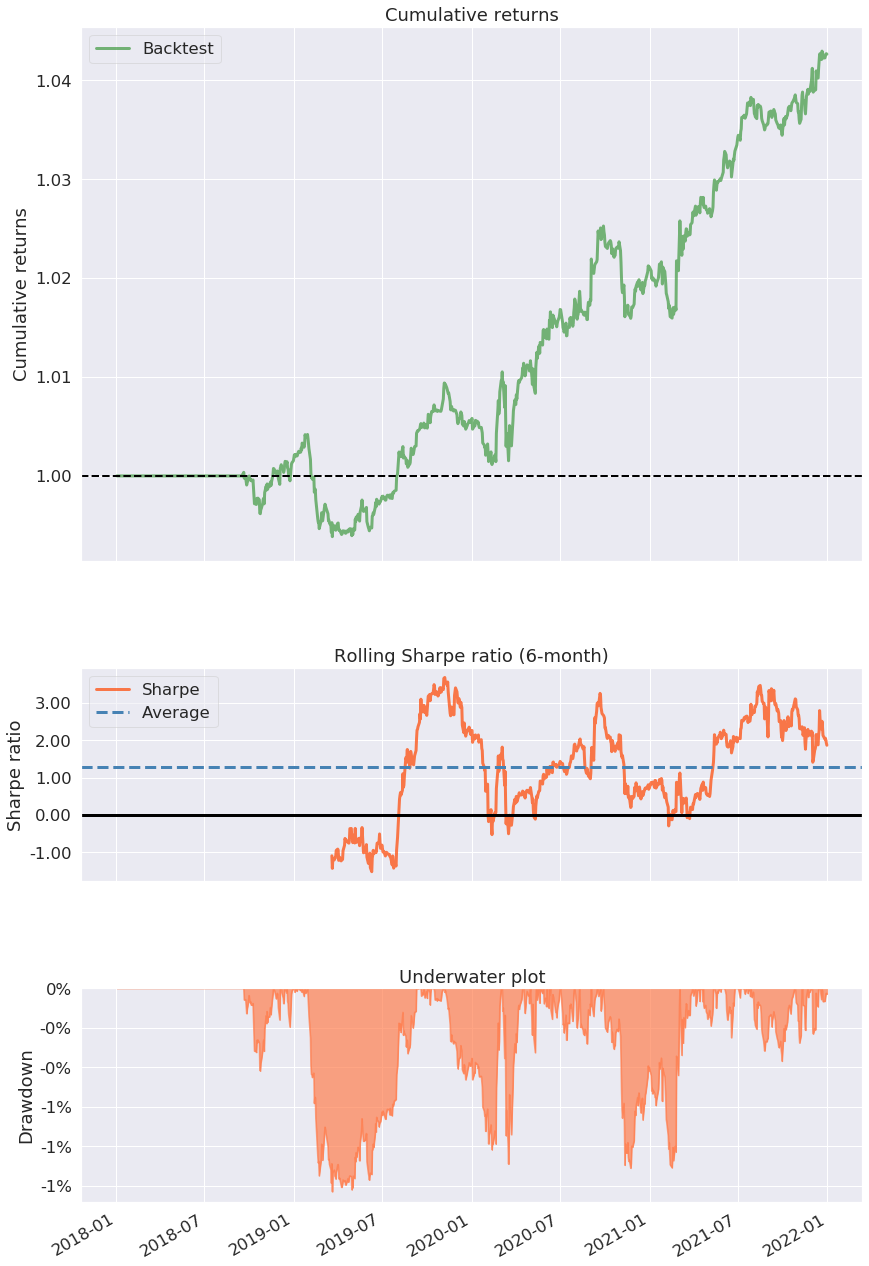

In [104]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 2 - filing date - no tc

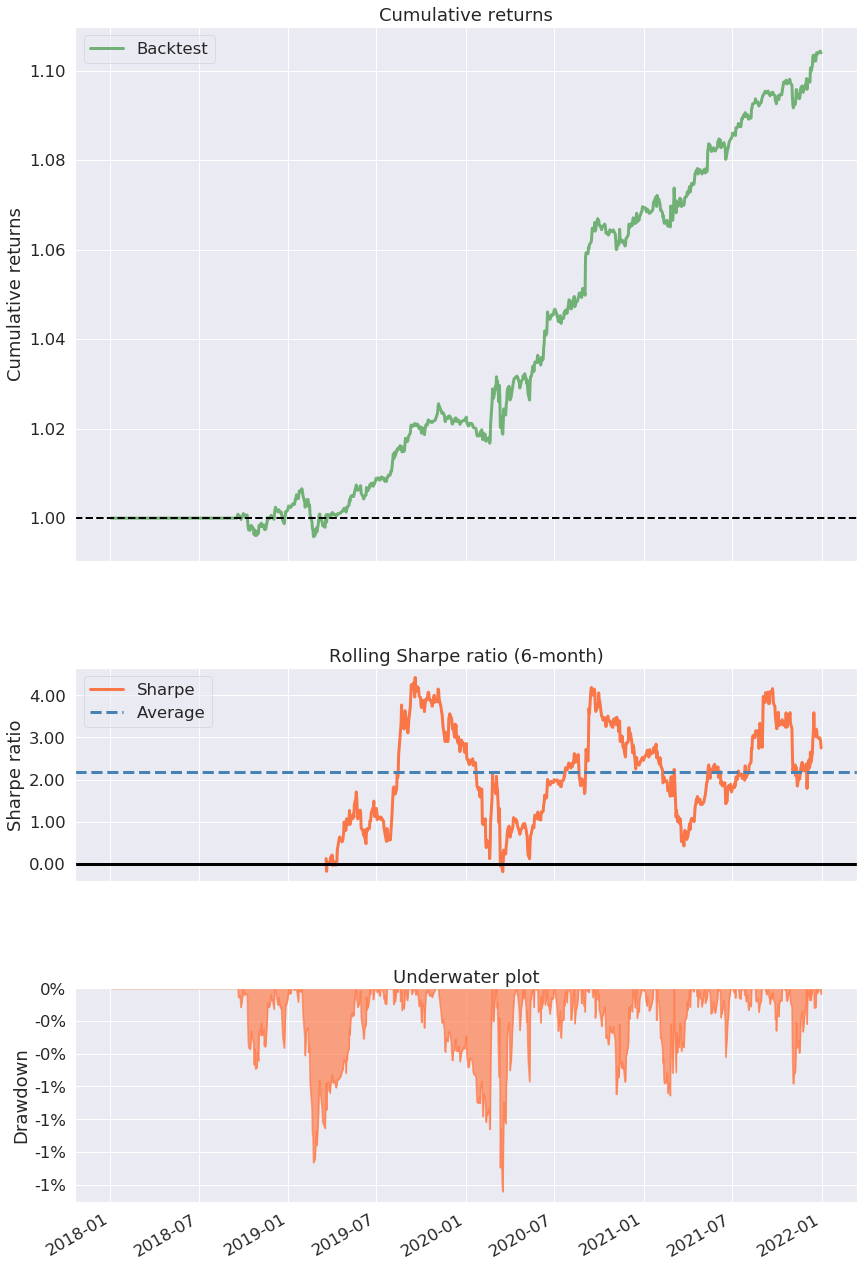

In [107]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 1 - filing date

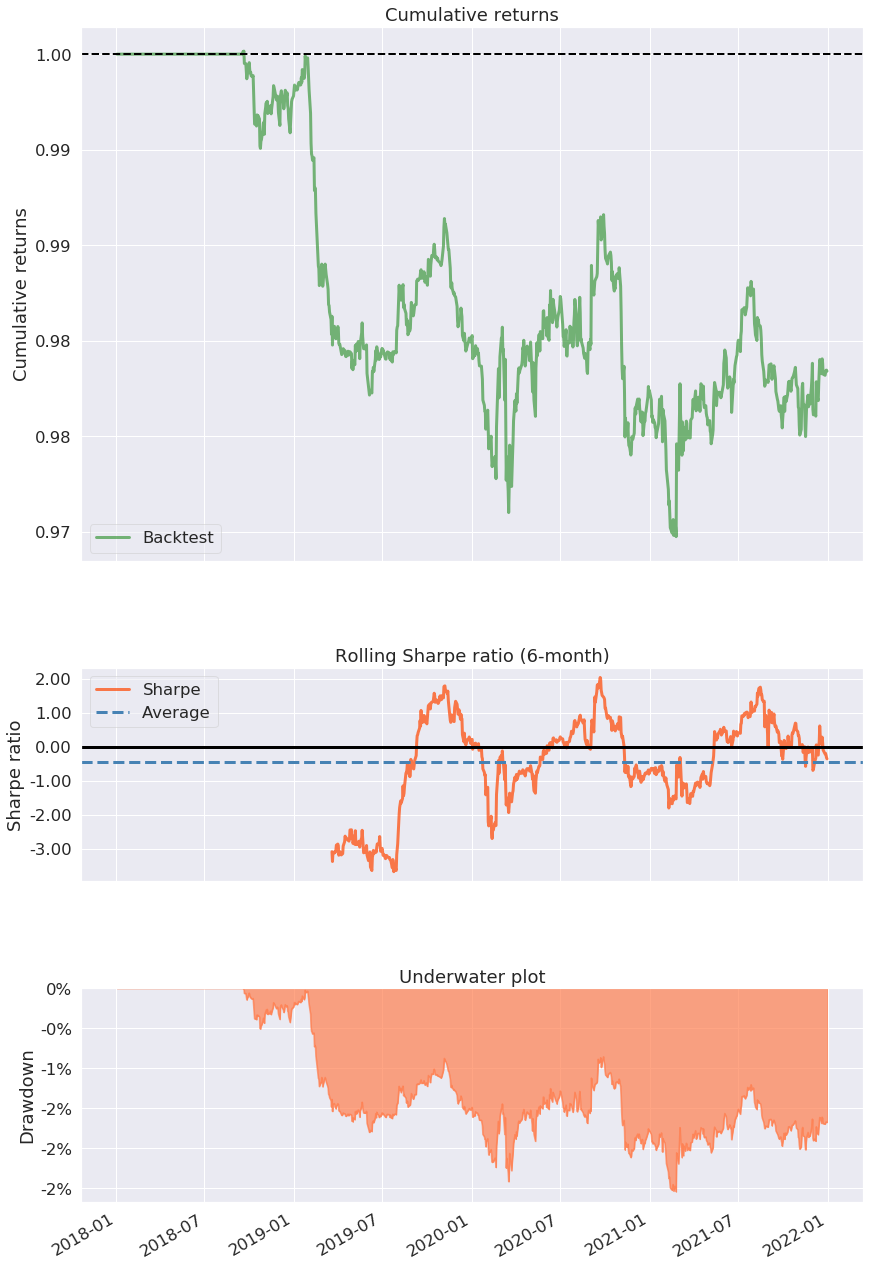

In [95]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 2 - filing date

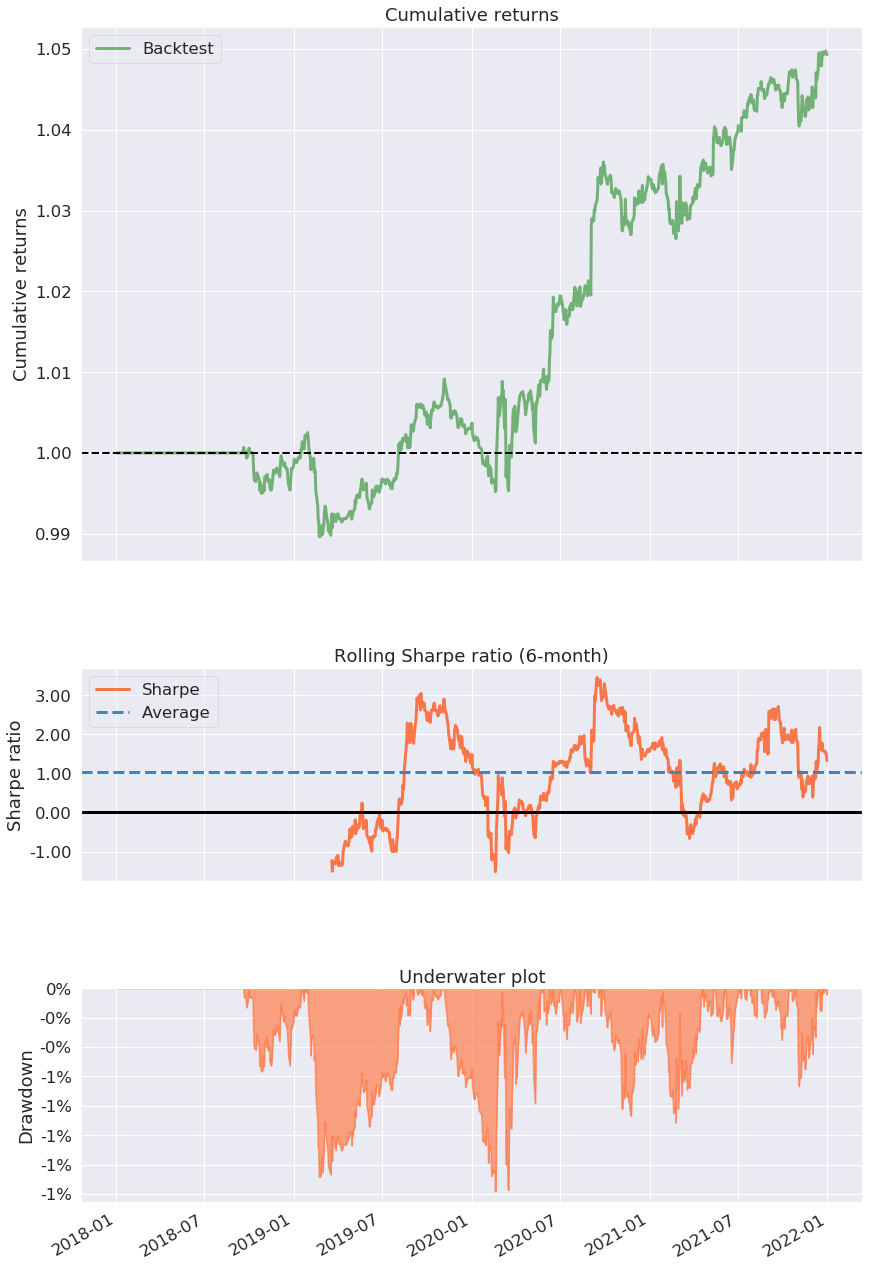

In [91]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 2 - long - filing date

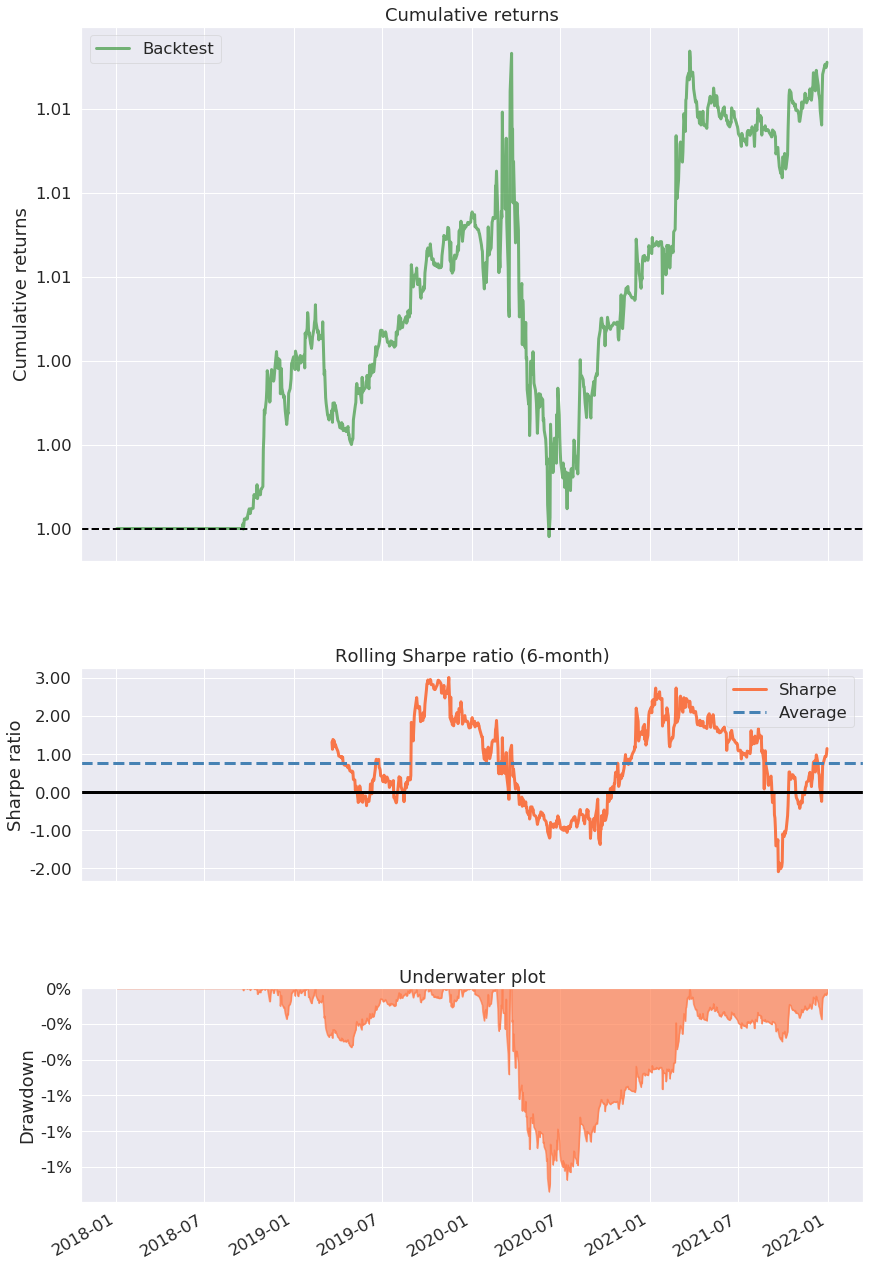

In [110]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 2 - short - filing date

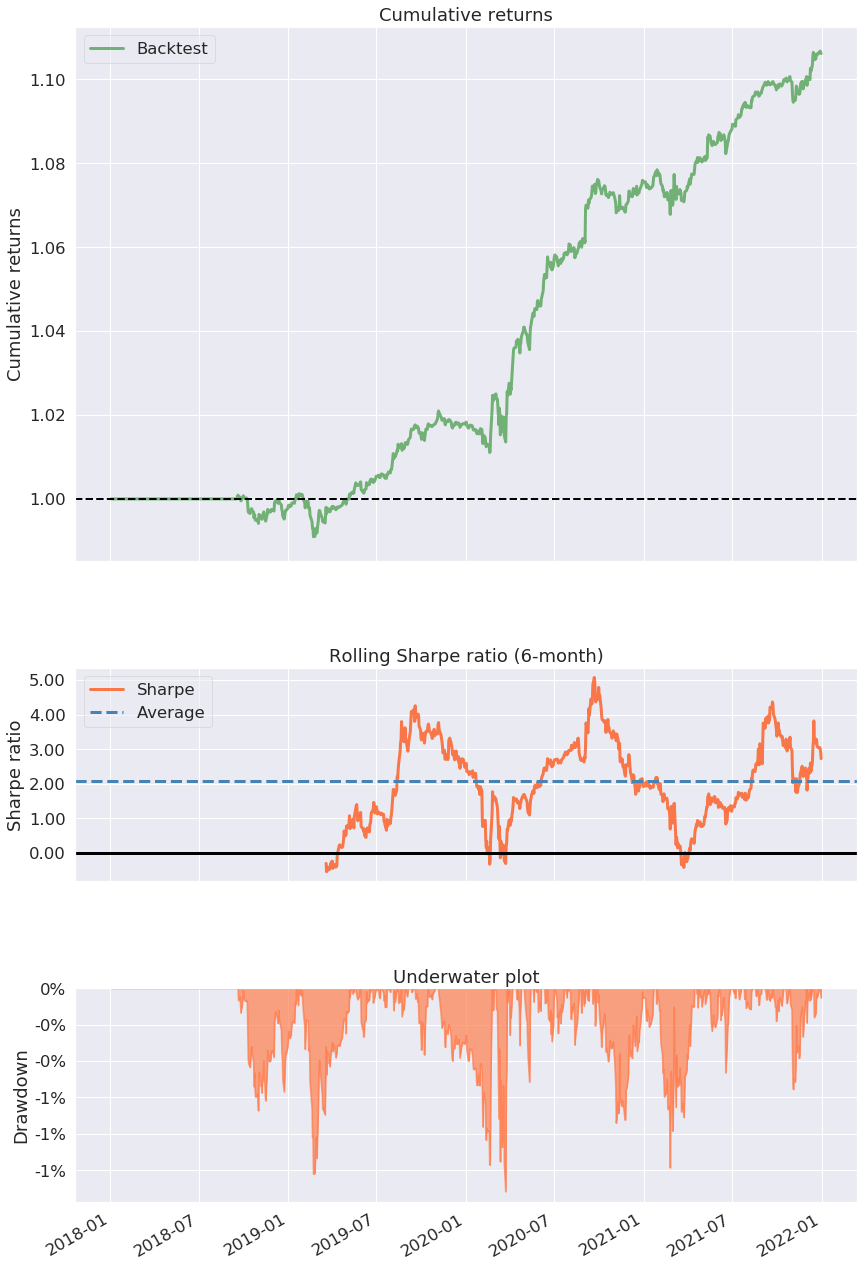

In [113]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 5 - filing date

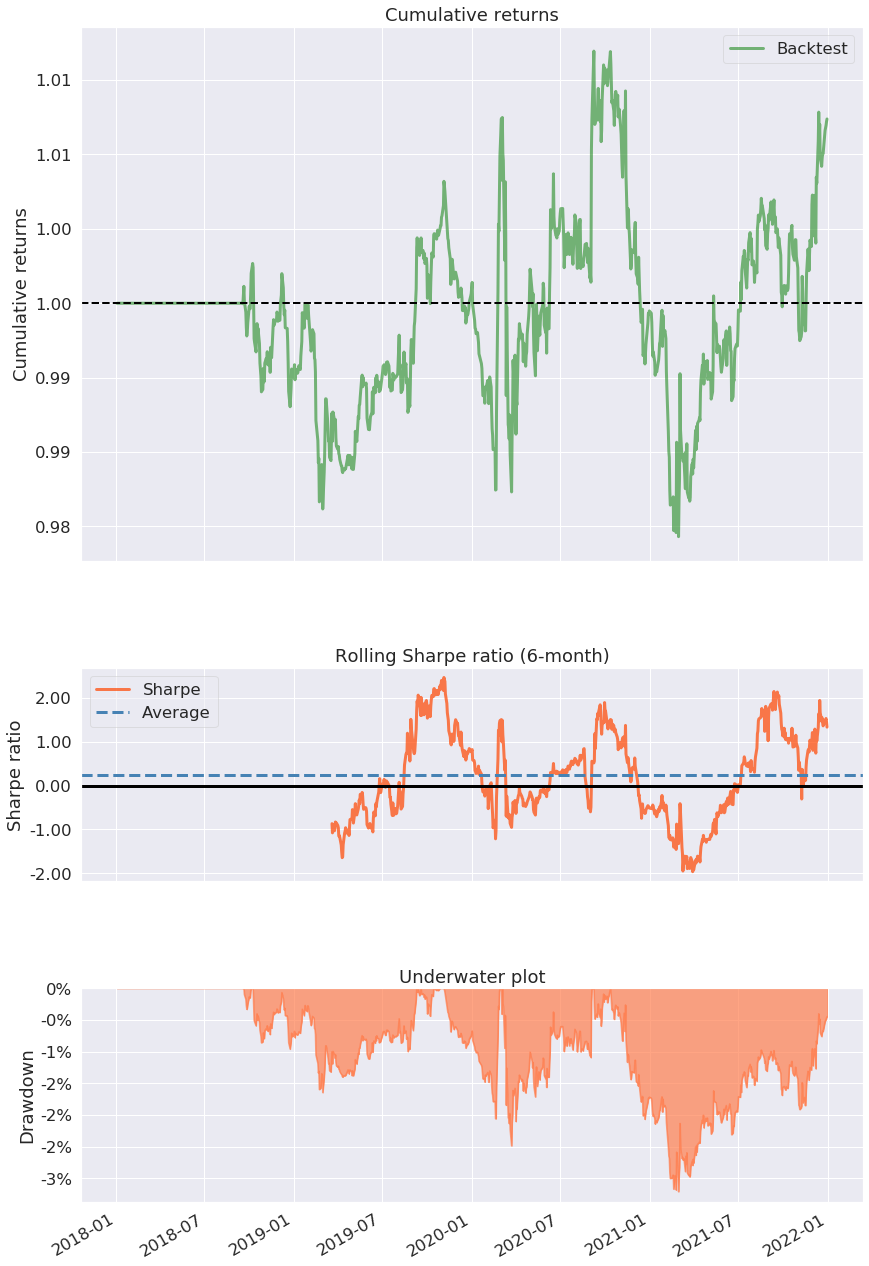

In [75]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 10 - filing date

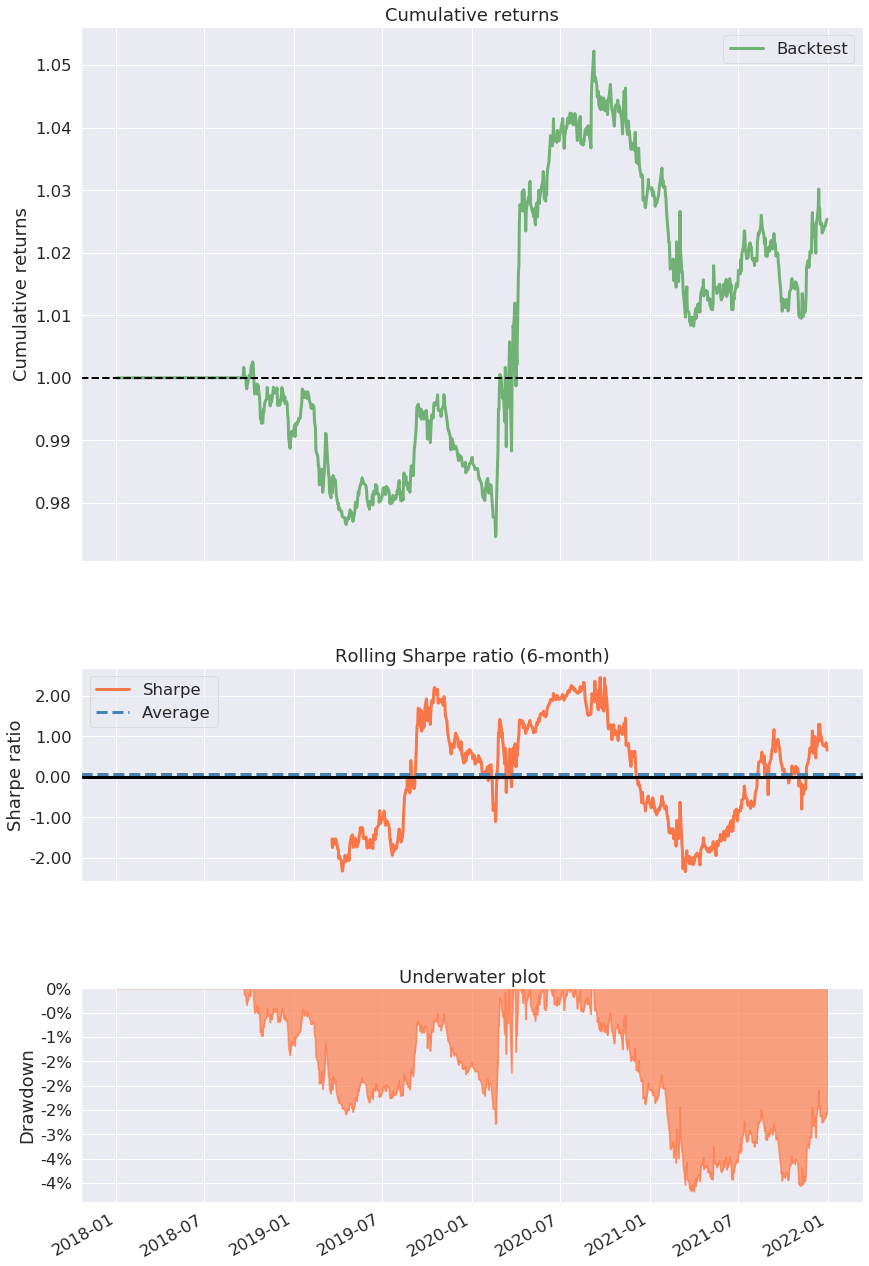

In [79]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 20 - filing date

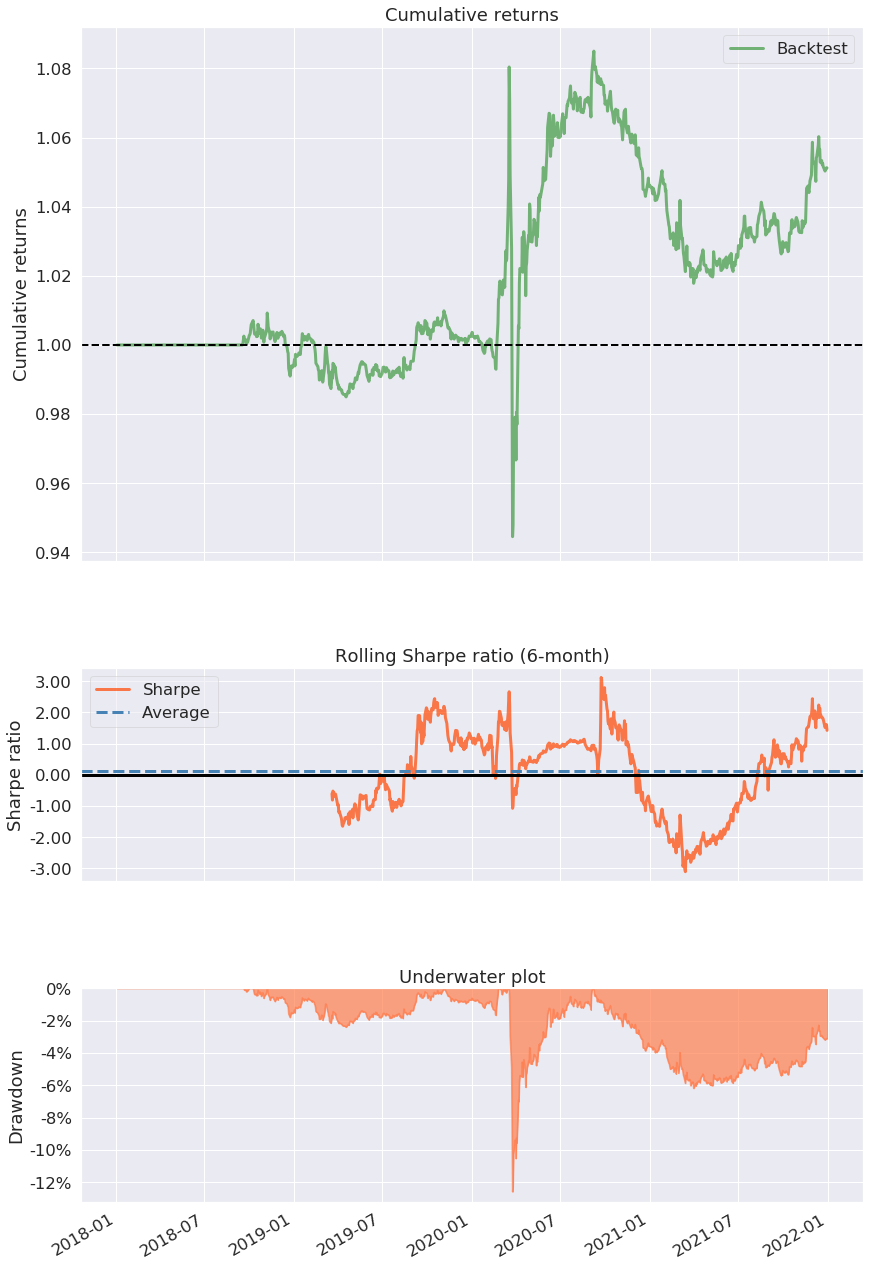

In [82]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 40 - filing date

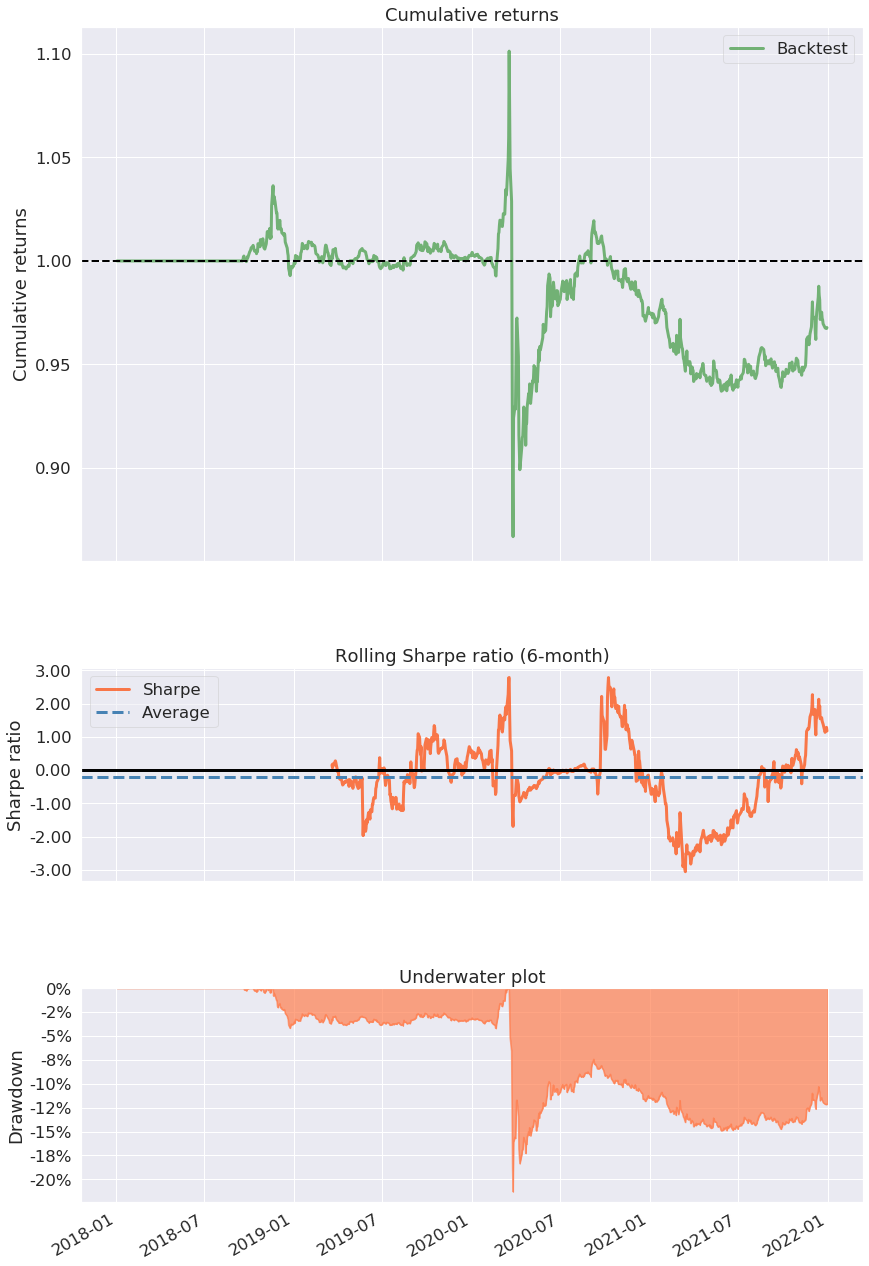

In [85]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)

holding period 60 -filing date

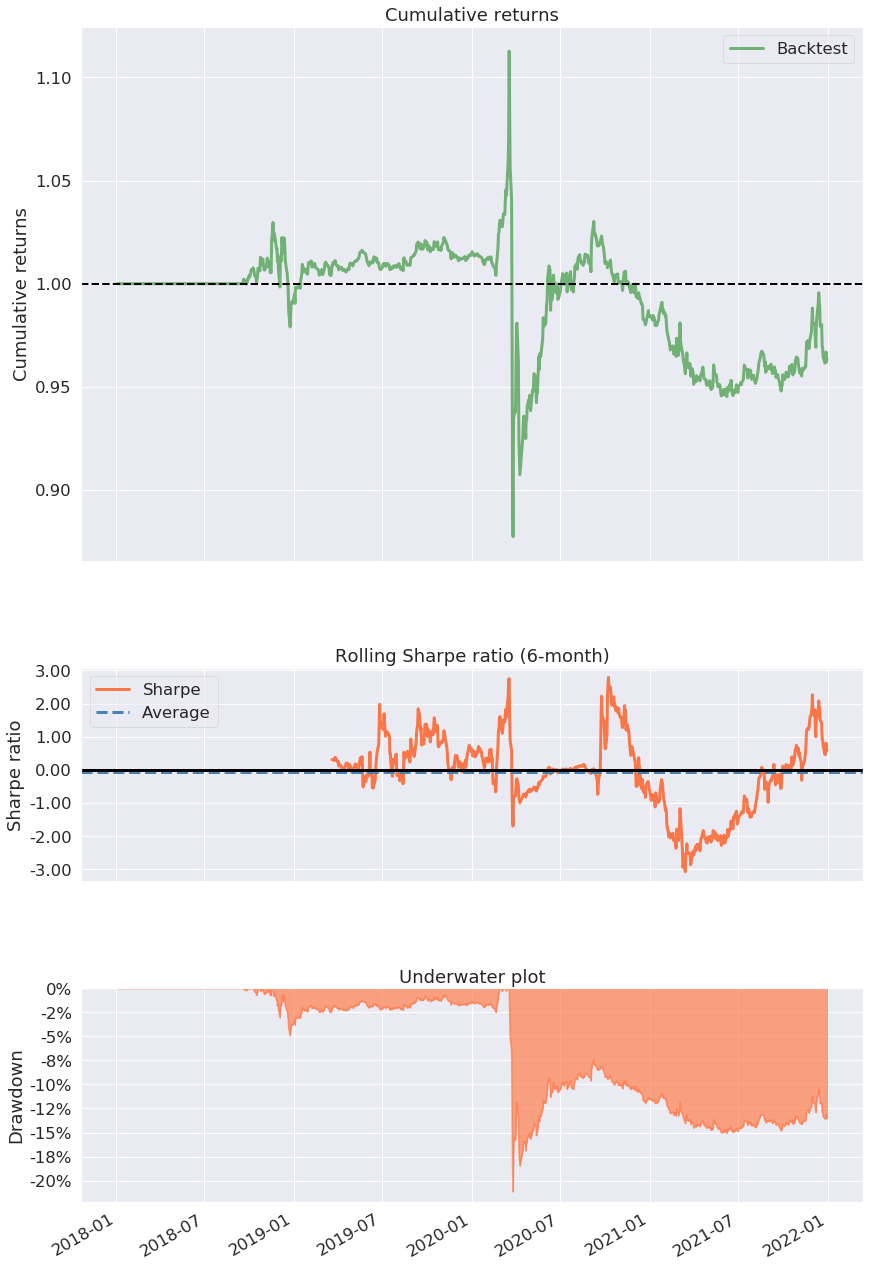

In [88]:
b, a = rolling_reg(sp500_beta, returns)
pyfolio.tears.create_simple_tear_sheet(returns - b * sp500_beta)